# Project 3a

This is the first part of the project. We will be exploring different kinds of methods to apply to our dataset.

## Submission Details

**Project is due June 13th at 11:59 pm (Friday Midnight). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend printing the notebook using [$\LaTeX$](https://www.latex-project.org/)**

## Loading Essentials and Helper Functions 

In [2]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

In [3]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 66
random.seed(SEED)

## Background: Dataset Information (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (male/female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [4]:
# Preprocess Data

# Load Data
data = pd.read_csv("datasets/heartdisease.csv")

# Transform target feature into numerical
le = LabelEncoder()
data["target"] = le.fit_transform(data["sick"])
data["sex"] = le.fit_transform(data["sex"])
data = data.drop(["sick"], axis=1)

# Split target and data
y = data["target"]
x = data.drop(["target"], axis=1)

# Train test split
# 35% in test data
train_raw, test_raw, target, target_test = train_test_split(
    x, y, test_size=0.35, stratify=y, random_state=0
)

# Feature Transformation
# This is the only change from project 2 since we replaced standard scaler to minmax
# This was done to ensure that the numerical features were still of the same scale
# as the one hot encoded features
num_pipeline = Pipeline([("minmax", MinMaxScaler())])

heart_num = train_raw.drop(
    ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"], axis=1
)
numerical_features = list(heart_num)
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories="auto"), categorical_features),
    ]
)

# Transform raw data|
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)  # Note that there is no fit calls

# Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [5]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [6]:
# Baseline accuracy of using the majority class
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print(
    "==========================================",
    "\nBaseline Accuraccy of using Majority Class:",
    np.round(np.max(ct) / np.sum(ct), 3),
)

Counts of each class in target_test: 
target
0    58
1    49
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class: 0.542


## 1. (15 pts) Decision Trees

### 1.1. [2.5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use `random_state = SEED` so that your results match ours.

In [7]:
# TODO
clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(train, target)
target_pred = clf.predict(test)
print('confusion matrix: ', confusion_matrix(target_test, target_pred))
print('accuracy: ', metrics.accuracy_score(target_test, target_pred))

confusion matrix:  [[46 12]
 [19 30]]
accuracy:  0.7102803738317757


### 1.2. [2.5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

[Text(0.5, 0.875, 'x[7] <= 0.5\ngini = 0.496\nsamples = 196\nvalue = [107, 89]'),
 Text(0.25, 0.625, 'x[4] <= 0.427\ngini = 0.305\nsamples = 96\nvalue = [78, 18]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[2] <= 0.233\ngini = 0.26\nsamples = 91\nvalue = [77, 14]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'x[2] <= 0.328\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'x[21] <= 0.5\ngini = 0.412\nsamples = 100\nvalue = [29.0, 71.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[16] <= 0.5\ngini = 0.109\nsamples = 52\nvalue = [3, 49]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'x[28] <= 0.5\ngini = 0.497\nsamples = 48\nvalue = [26, 22]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

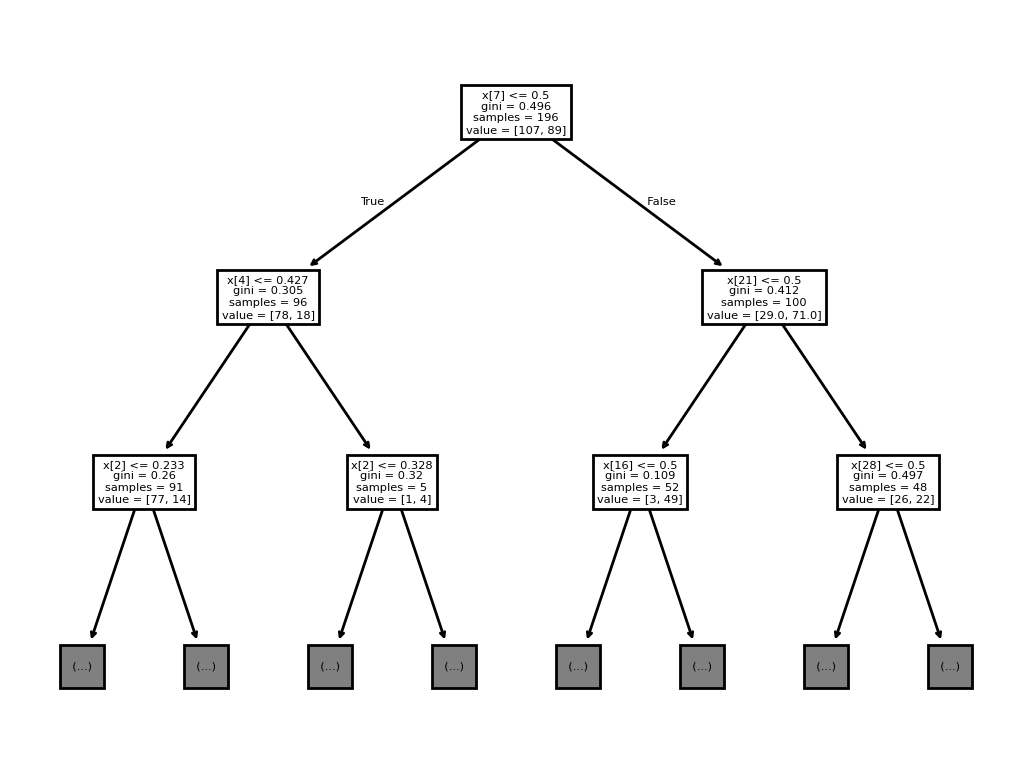

In [21]:
# TODO
tree.plot_tree(clf, max_depth=2)

**What is the gini index improvement of the first split? Give an interpretation of the result**

Response: The Gini gain of the first split is given by 0.496 - ((96/196)(0.305) + (100/196)(0.412)) = 0.136. This means that this split made the resulting nodes more class-pure.

### [2.5 pts] Plot the importance of each feature for the Decision Tree

13

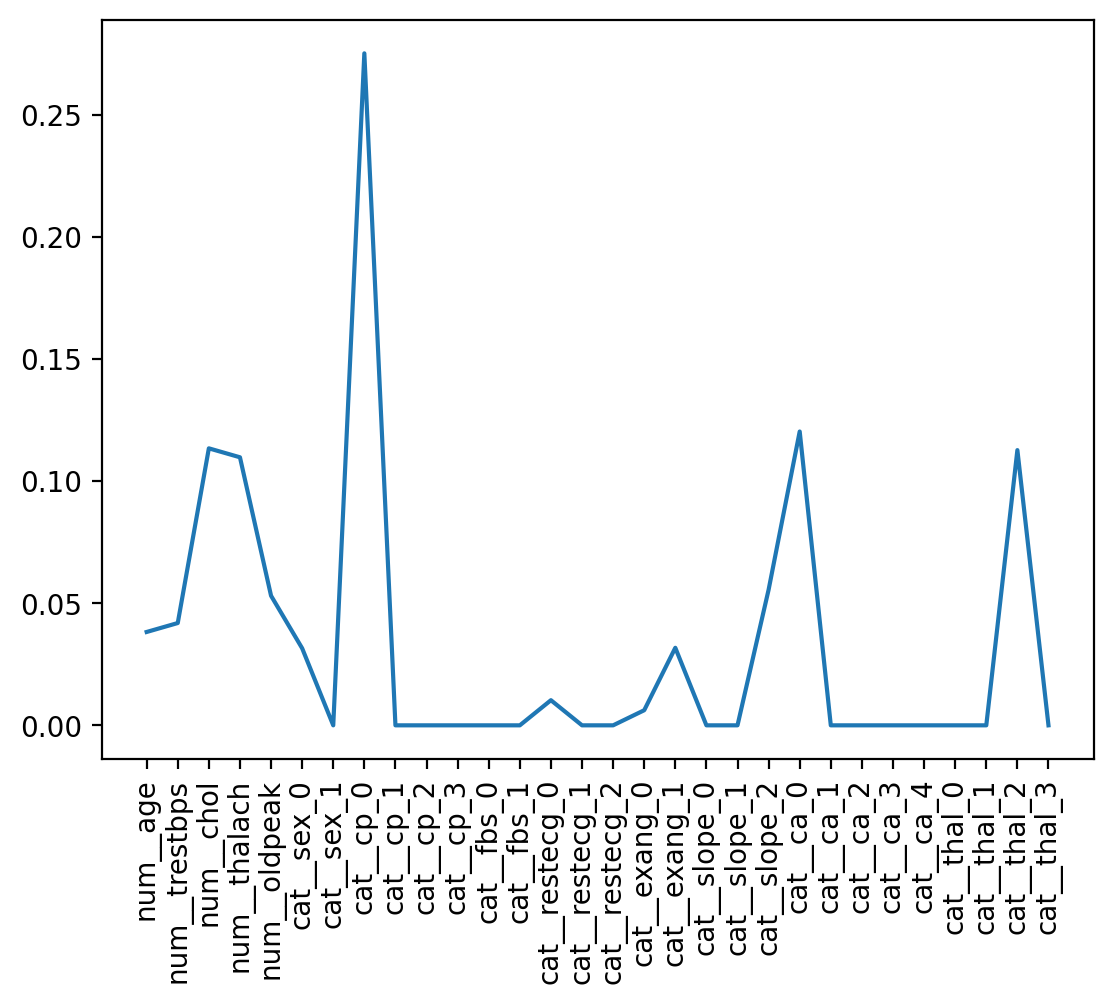

In [ ]:
# TODO
plt.plot(feature_names, clf.feature_importances_)
plt.xticks(rotation=90)
np.count_nonzero(clf.feature_importances_)

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

Response: There are 13 nonzero feature importances in the DT. If we remove the features and then retrain, the tree will change. If we remove them without retraining or changing the model, the decision tree will stay the same.

### [7.5 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a `GridSearchCV` with 5-Fold Cross Validation for the Decision Tree. Find the best model parameters for accuracy amongst the following:

- `max_depth` = [4, 8, 16, 32, 64]
- `min_samples_split` = [4, 8, 16, 32]
- `criterion` = [`gini`, `entropy`, `log_loss`]

After using `GridSearchCV`, Print the **best 10 models** with the following parameters: `rank_test_score`, `param_max_depth`, `param_min_samples_split`, `param_criterion`, `mean_test_score`, `std_test_score`.


In [61]:
# TODO
param_grid = {'max_depth': [4,8,16,32,64],
              'min_samples_split': [4,8,16,32],
              'criterion': ['gini', 'entropy', 'log_loss']}
cv = GridSearchCV(clf, param_grid=param_grid)
cv.fit(train, target)
results = pd.DataFrame(cv.cv_results_)
top10 = results.sort_values('rank_test_score').head(10)
top10
print(top10[['rank_test_score', 'param_max_depth', 'param_min_samples_split', 'param_criterion', 'mean_test_score', 'std_test_score']])

    rank_test_score  param_max_depth  param_min_samples_split param_criterion  \
42                1                4                       16        log_loss   
22                1                4                       16         entropy   
4                 3                8                        4            gini   
16                3               64                        4            gini   
8                 3               16                        4            gini   
12                3               32                        4            gini   
50                7               16                       16        log_loss   
30                7               16                       16         entropy   
46                7                8                       16        log_loss   
34                7               32                       16         entropy   

    mean_test_score  std_test_score  
42         0.754744        0.051454  
22         0.754744        0.051

**Using the best model you have, report the test accuracy and print out the confusion matrix**

In [62]:
y_pred = cv.best_estimator_.predict(test)
print('test accuracy of best model is ', metrics.accuracy_score(target_test, y_pred))
print('confusion matrix: ', confusion_matrix(target_test, y_pred))

test accuracy of best model is  0.7850467289719626
confusion matrix:  [[50  8]
 [15 34]]


## (10 pts) Multi-Layer Perceptron

### [2.5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(100, 100) and max_iter = 1000. **Report the accuracy and print the confusion matrix**. Make sure to set `random_state=SEED`. 

In [29]:
# TODO
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=SEED)
mlp.fit(train, target)
mlp_pred = mlp.predict(test)
print('confusion matrix: ', confusion_matrix(target_test, mlp_pred))
print('accuracy: ', metrics.accuracy_score(target_test, mlp_pred))

confusion matrix:  [[52  6]
 [12 37]]
accuracy:  0.8317757009345794


### [5 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [30]:
dt = DecisionTreeClassifier()

start = time.time()
dt.fit(train, target)
dt_fit_time = time.time() - start

start = time.time()
mlp.fit(train, target)
mlp_fit_time = time.time() - start

start = time.time()
dt_pred = dt.predict(test)
dt_pred_time = time.time() - start

start = time.time()
mlp_pred = mlp.predict(test)
mlp_pred_time = time.time() - start

print(f'dt fit time: {dt_fit_time}, mlp fit time: {mlp_fit_time}')
print(f'dt pred time: {dt_pred_time}, mlp pred time: {mlp_pred_time}')

dt fit time: 0.003628969192504883, mlp fit time: 0.16103410720825195
dt pred time: 0.00019097328186035156, mlp pred time: 0.00019121170043945312


Response: The decision tree fit in 3.63 ms and predicted in 0.191 ms. The MLP fit in 161 ms and predicted in 0.191 ms.

### [2.5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

Response: MLP is advantageous in that it can better model complex nonlinear relationships, but it's disadvantageous in that it trains much more slowly than a decision tree.

## (15 pts) PCA

### [2.5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 8 components. **Print out the 8 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [39]:
# TODO
pca = PCA(n_components=8, random_state=SEED)
pca.fit(train)
print(pca.components_)

[[-5.88824889e-02 -3.60497119e-02 -1.70206867e-02  1.03789323e-01
  -1.12949393e-01  1.34058041e-01 -1.34058041e-01 -3.43838552e-01
   1.49148921e-01  1.90743643e-01  3.94598830e-03  1.77659035e-04
  -1.77659035e-04 -1.62590021e-01  1.64229135e-01 -1.63911390e-03
   3.49296677e-01 -3.49296677e-01 -4.42573564e-02 -2.98125292e-01
   3.42382648e-01  2.09179099e-01 -8.88114413e-02 -7.37523677e-02
  -6.43314353e-02  1.77161452e-02  2.71173534e-04 -4.76811068e-02
   3.30445838e-01 -2.83035904e-01]
 [-6.13278432e-02 -3.30647171e-02 -3.82416019e-02  1.28970449e-02
   6.12059254e-04 -4.16087229e-01  4.16087229e-01 -6.75333095e-02
   2.01325731e-02  4.83244503e-02 -9.23713979e-04  5.36809382e-02
  -5.36809382e-02 -4.76354860e-01  4.90696705e-01 -1.43418452e-02
  -1.66001158e-02  1.66001158e-02  1.61815136e-02 -1.26976371e-01
   1.10794857e-01  1.37704407e-02  1.88951894e-02 -5.13584946e-02
  -9.62605522e-03  2.83189197e-02 -2.43409967e-03  1.79759764e-03
  -2.57549131e-01  2.58185633e-01]
 [ 4.3

### [2.5 pts] Percentage of variance explained by top 8 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 8 principal components.

In [11]:
# TODO
print(pca.explained_variance_ratio_)

[0.23402653 0.13971516 0.1008586  0.08111106 0.07509131 0.06754254
 0.05991491 0.04951331]


### [2.5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [40]:
# TODO
train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)

### [2.5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

In [13]:
# TODO
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(train_pca, target)
pca_dt_pred = dt.predict(test_pca)
print('confusion matrix: ', confusion_matrix(target_test, pca_dt_pred))
print('accuracy: ', metrics.accuracy_score(target_test, pca_dt_pred))

confusion matrix:  [[50  8]
 [15 34]]
accuracy:  0.7850467289719626


**Does the model perform better with or without PCA? Give an explanation**

Response: The decision tree performs slightly better with PCA because PCA reduces correlation between features and the potential for overfitting.

### [2.5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

In [14]:
# TODO
mlp_pca = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000, random_state=SEED)
mlp_pca.fit(train_pca, target)
pca_mlp_pred = mlp_pca.predict(test_pca)
print('confusion matrix: ', confusion_matrix(target_test, pca_mlp_pred))
print('accuracy: ', metrics.accuracy_score(target_test, pca_mlp_pred))

confusion matrix:  [[49  9]
 [13 36]]
accuracy:  0.794392523364486


**Does the model perform better with or without PCA? Give an explanation**

Response: The MLP performs worse with PCA, likely because PCA functions linearly and MLP is a nonlinear classifier. With that in mind, PCA may obfuscate the relationships between feature data for MLP.

### [2.5 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

Response: 
Pros: Effectively reduces dimensionality, prevents extreme overfitting.
Cons: Assumes linear relationships between features, reduces interpretability of principal components / combinations of features.

## (10 pts) K-Means Clustering

### [2.5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 15 and `random_state = SEED`.

In [31]:
# TODO
km = KMeans(n_clusters=15, random_state=SEED)
km.fit(train)
print(km.inertia_)

385.51181909863436


### [5 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 30. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use `random_state = SEED`.

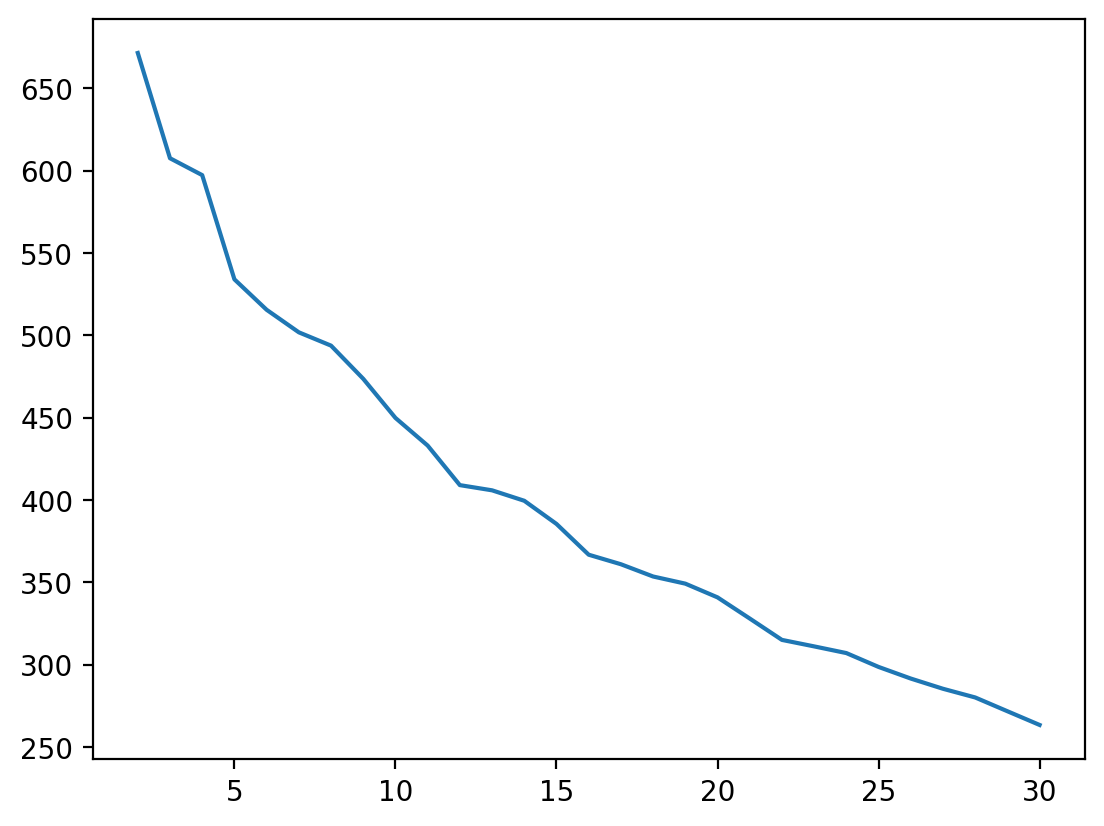

In [63]:
# TODO
inertias = []
for i in range(2, 31):
    kmeans = KMeans(n_clusters=i, random_state=SEED)
    kmeans.fit(train)
    inertias.append(kmeans.inertia_)
plt.plot(range(2, 31), inertias)

**What seems to be the best range of cluster sizes?**

Response: It seems like k=6 to k=10 is the best range of cluster sizes because this is where the elbow seems most visible.

### [2.5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

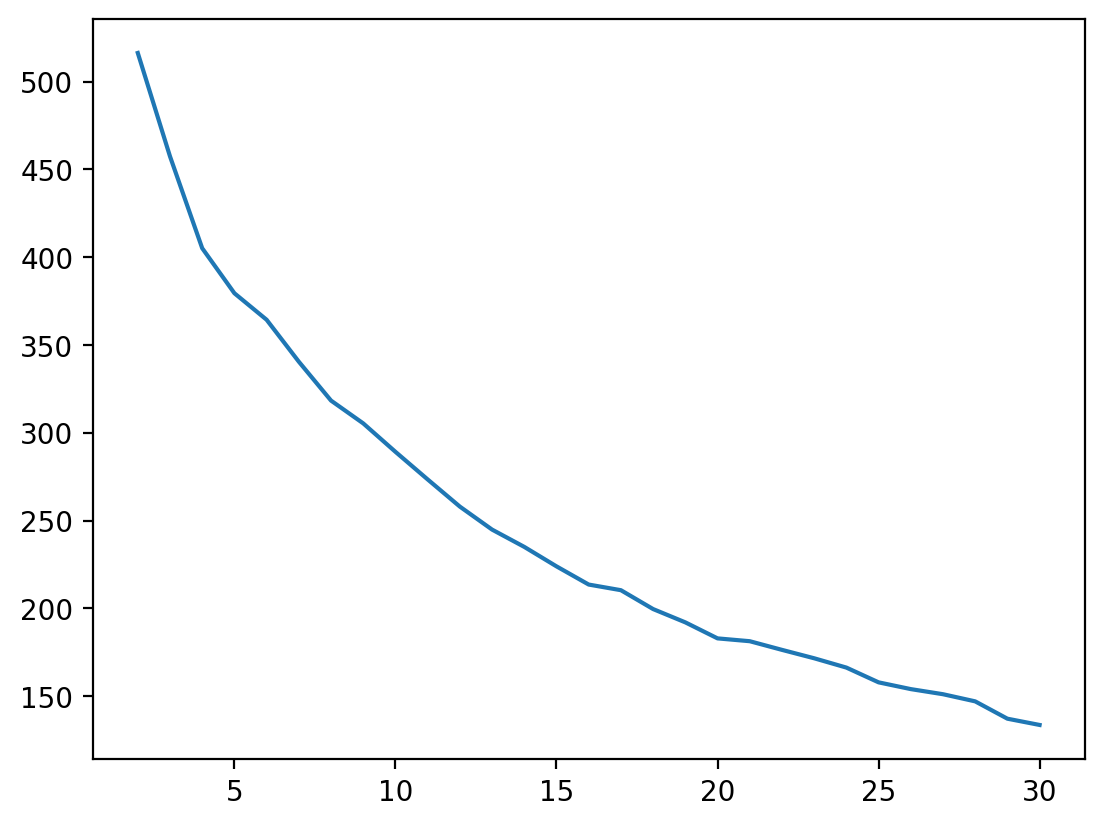

In [64]:
# TODO
inertias = []
for i in range(2, 31):
    kmeans = KMeans(n_clusters=i, random_state=SEED)
    kmeans.fit(train_pca)
    inertias.append(kmeans.inertia_)
plt.plot(range(2, 31), inertias)

**What seems to be the best range of cluster sizes? Explain as well any differences between the resulting curve and the one from the previous exercise.**

Response: It looks like k=7 to k=10 is the best range here. This curve has lower overall inertia compared to the previous curve because PCA-transformed data often results in lower within-cluster distances and lower inertia as such.